In [1]:
import torch
import torch.optim as optim
import numpy as np
import json
from pathlib import Path
from collections import Counter
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import Vocab, vocab
from torch.nn.utils.rnn import pack_padded_sequence
import nltk
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import random

In [2]:
dev_path = Path("train-taskA.jsonl")
test_path = Path("test-news-taskA.jsonl")
test_path2 = Path("test-tweets-taskA.jsonl")

In [3]:
def count_lines(path: Path) -> int:
    with open(path, "rb") as f:
        return sum(1 for _ in f)
count_lines(dev_path), count_lines(test_path), count_lines(test_path2)

(6839, 500, 1263)

In [15]:
### Constants ###
pad_token, unk_token = "<pad>", "<unk>"
device = "cuda"

### Dataset Creation ###
class CustomDataset(Dataset):
    def __init__(self, data_path):
        self.samples = []
        with open(data_path, "r") as f:
            for line in f:
                sample = json.loads(line.strip())
                sample["tokens"] = word_tokenize(sample["text"].translate(str.maketrans('', '', string.punctuation)), language='italian')
                self.samples.append(sample)

        vocab_counter = dict(Counter(token for sent in self.samples for token in sent["tokens"]).most_common())
        self.vocabulary = {pad_token: 0, unk_token: 1}
        for token in vocab_counter.keys():
            if token not in self.vocabulary:
                self.vocabulary[token] = len(self.vocabulary)

        self.padding_id = self.vocabulary[pad_token]

        self.indexed_data = []
        for sample in self.samples:
            input_ids = [self.vocabulary.get(token, self.vocabulary[unk_token]) for token in sample["tokens"]]
            self.indexed_data.append({"input_ids": input_ids, "label": sample["label"]})

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.indexed_data[idx]


In [16]:
def _collate_fn(raw_batch, padding_id):
    sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype=torch.long)
    padded_sequence = pad_sequence(
        (
            torch.tensor(sample["input_ids"], dtype=torch.long, device=device)
            for sample in raw_batch
        ),
        batch_first=True,
        padding_value=padding_id
    )
    labels = torch.tensor([sample["label"] for sample in raw_batch], device=device, dtype=torch.long)
    return sequence_lengths, padded_sequence, labels

In [17]:
dataset = CustomDataset(dev_path)
training_dataloader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=lambda batch: _collate_fn(batch, dataset.padding_id))

# Create test datasets
test_dataset1 = CustomDataset(test_path)
test_dataset2 = CustomDataset(test_path2)

# DataLoader for test datasets
test_dataloader1 = DataLoader(test_dataset1, batch_size=128, shuffle=False, collate_fn=lambda batch: _collate_fn(batch, test_dataset1.padding_id))
test_dataloader2 = DataLoader(test_dataset2, batch_size=128, shuffle=False, collate_fn=lambda batch: _collate_fn(batch, test_dataset2.padding_id))


In [18]:
len(dataset.vocabulary)

25392

<h2>Baseline Model With Early Stoping

The first model consist of simple LSTM model which consist of embedding layers, couple of LSTM layer and linear layer in the end. 

In [19]:
### Model Definition ###
class LSTMModel(nn.Module):
    def __init__(self, vocabulary_size, hidden_dim, num_layers, dropout, num_classes, padding_id):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_size,
            embedding_dim=hidden_dim,
            padding_idx=padding_id
        )
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False  # Change this to False for a regular LSTM
        )
        self.projection = nn.Linear(
            in_features=hidden_dim, 
            out_features=num_classes
        )

    def forward(self, batch):
        sequence_lengths, input_ids = batch
        embeds = self.embedding(input_ids)
        packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden_state, cell_state) = self.lstm(packed)
        logits = self.projection(hidden_state[-1])  # Select the last hidden state for classification
        return logits

In [167]:
### Model and Optimization Setup ###
model = LSTMModel(
    vocabulary_size=len(dataset.vocabulary),
    hidden_dim=32,
    num_layers=3,
    dropout=0.4,
    num_classes=2,
    padding_id=dataset.padding_id
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001 )#weight_decay = 0.001
loss_function = nn.CrossEntropyLoss()

In [168]:
# Define the size of your validation set
validation_split = 0.10  # 20% of the data will be used for validation

# Calculate the size of the validation set
validation_size = int(validation_split * len(dataset))
train_size = len(dataset) - validation_size
#  Split the dataset into training and validation sets
random.seed(42)
torch.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, validation_size])
# DataLoader for training and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=lambda batch: _collate_fn(batch, dataset.padding_id))
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=lambda batch: _collate_fn(batch, dataset.padding_id))

<h3>Training Loop

In [169]:
#  Set up early stopping parameters
epochs=30
validation_losses=[]
validation_accuracies=[]
train_losses = []
train_accuracies = []

best_validation_loss = float('inf')
best_validation_acc = float('inf')
best_model_state = None
patience = 2  # Number of epochs to wait for improvement
wait = 0  # Current number of epochs without improvement

# Training Loop with Early Stopping
for epoch in range(1, epochs + 1):
    print(' Epoch # {:1d}'.format(epoch))

    # Training Phase
    model.train()
    epoch_train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    for step, (lens, inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predictions = model((lens, inputs))
        train_loss = loss_function(predictions, labels)
        train_loss.backward()
        optimizer.step()
        epoch_train_loss += train_loss.item()

        _, predicted = torch.max(predictions, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.size(0)

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_accuracies.append(train_accuracy)

    print('\ttrain loss = {:.4f}, train accuracy = {:.4f}'.format(
        epoch, avg_train_loss, train_accuracy))

    # Validation Phase
    model.eval()
    validation_loss = 0.0
    correct_validation_predictions = 0
    total_validation_predictions = 0

    with torch.no_grad():
        for lens, inputs, labels in val_dataloader:
            predictions = model((lens, inputs))
            validation_loss += loss_function(predictions, labels).item()

            _, predicted = torch.max(predictions, 1)
            correct_validation_predictions += (predicted == labels).sum().item()
            total_validation_predictions += labels.size(0)

        avg_validation_loss = validation_loss / len(val_dataloader)
        validation_losses.append(avg_validation_loss)
        validation_accuracy = correct_validation_predictions / total_validation_predictions
        validation_accuracies.append(validation_accuracy)

        print('\tvalidation loss = {:.4f}, validation accuracy = {:.4f}'.format(
            epoch, avg_validation_loss, validation_accuracy))

       
        if avg_validation_loss < best_validation_loss:
            best_validation_loss = avg_validation_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered. No improvement in validation loss.")
                break

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)

 Epoch # 1
	[E:  1] train loss = 0.6878, train accuracy = 0.5960
	[E:  1] validation loss = 0.6850, validation accuracy = 0.5900
 Epoch # 2
	[E:  2] train loss = 0.6821, train accuracy = 0.5962
	[E:  2] validation loss = 0.6807, validation accuracy = 0.5900
 Epoch # 3
	[E:  3] train loss = 0.6778, train accuracy = 0.5962
	[E:  3] validation loss = 0.6773, validation accuracy = 0.5900
 Epoch # 4
	[E:  4] train loss = 0.6723, train accuracy = 0.5962
	[E:  4] validation loss = 0.6752, validation accuracy = 0.5900
 Epoch # 5
	[E:  5] train loss = 0.6724, train accuracy = 0.5962
	[E:  5] validation loss = 0.6740, validation accuracy = 0.5900
 Epoch # 6
	[E:  6] train loss = 0.6682, train accuracy = 0.5962
	[E:  6] validation loss = 0.6722, validation accuracy = 0.5900
 Epoch # 7
	[E:  7] train loss = 0.6686, train accuracy = 0.5962
	[E:  7] validation loss = 0.6694, validation accuracy = 0.5900
 Epoch # 8
	[E:  8] train loss = 0.6611, train accuracy = 0.5962
	[E:  8] validation loss = 0.665

<h3>Testing on Test dataset # 01

In [170]:
# Testing Phase on separate test set (test_dataset1)
model.eval()
test_loss = 0.0
correct_test_predictions = 0
total_test_predictions = 0

with torch.no_grad():
    for lens, inputs, labels in test_dataloader1:
        predictions = model((lens, inputs))
        test_loss += loss_function(predictions, labels).item()

        _, predicted = torch.max(predictions, 1)
        correct_test_predictions += (predicted == labels).sum().item()
        total_test_predictions += labels.size(0)

avg_test_loss = test_loss / len(test_dataloader1)
test_accuracy = correct_test_predictions / total_test_predictions

print('Test Loss: {:.3f}, Test Accuracy: {:.3f}%'.format(avg_test_loss, test_accuracy*100))

Test Loss: 0.723, Test Accuracy: 53.200%


<h3>Testing on Test dataset # 02

In [171]:
# Testing Phase on separate test set (test_dataset1)
test_loss = 0.0
correct_test_predictions = 0
total_test_predictions = 0

with torch.no_grad():
    for lens, inputs, labels in test_dataloader2:
        predictions = model((lens, inputs))
        test_loss += loss_function(predictions, labels).item()

        _, predicted = torch.max(predictions, 1)
        correct_test_predictions += (predicted == labels).sum().item()
        total_test_predictions += labels.size(0)

avg_test_loss_2 = test_loss / len(test_dataloader2)
test_accuracy_2 = correct_test_predictions / total_test_predictions

print('Test Loss: {:.4f}, Test Accuracy: {:.3f}%'.format(avg_test_loss_2, test_accuracy_2*100))

Test Loss: 0.8413, Test Accuracy: 48.931%


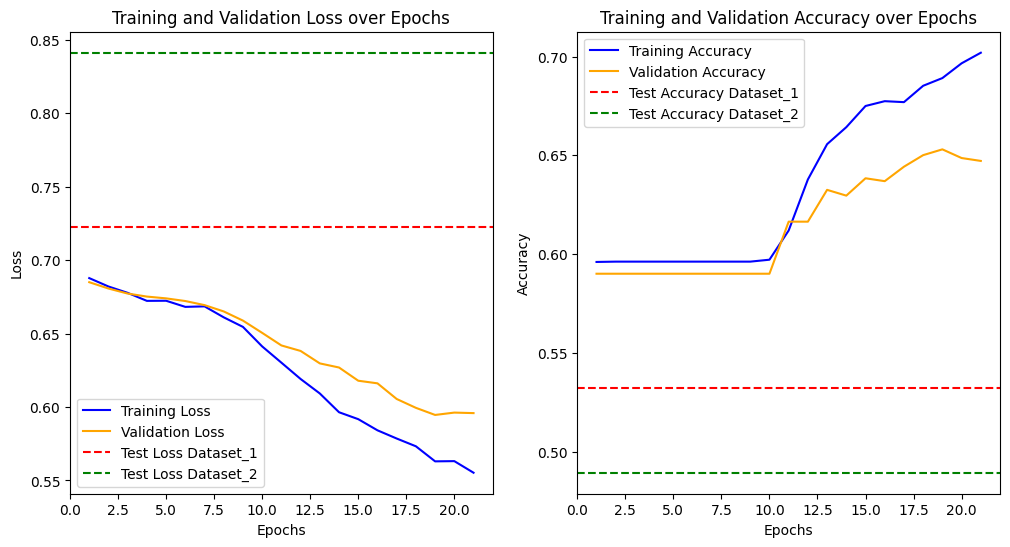

In [173]:
# Plotting Loss and Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', color='orange')
plt.axhline(y=avg_test_loss, color='red', linestyle='--', label='Test Loss Dataset_1')
plt.axhline(y=avg_test_loss_2, color='green', linestyle='--', label='Test Loss Dataset_2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='orange')
plt.axhline(y=test_accuracy, color= 'red', linestyle='--', label='Test Accuracy Dataset_1')
plt.axhline(y=test_accuracy_2, color= 'green', linestyle='--', label='Test Accuracy Dataset_2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.show()

<h4>CNN-LSTM Hybrid  - Extra 

The second model is LSTM-CNN Hybrid model, CNNs are excellent at capturing local patterns and features in data, while LSTMs are proficient in understanding temporal dependencies. Combining them allows for hierarchical feature extraction, where CNNs can extract low-level features, and LSTMs can learn higher-level temporal patterns from these features. CNNs are also prone to overfitting when trained on limited data, especially for tasks with small datasets. This model consist of embedding layer followed by three 1D convolutional layers, simple LSTM layers and then in the end linear layer for prediction.

In [174]:
class CNNLSTMModel(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim, num_filters, filter_sizes, hidden_dim, num_layers, dropout, num_classes, padding_id):
        super(CNNLSTMModel, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_size,
            embedding_dim=embedding_dim,
            padding_idx=padding_id
        )
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs) for fs in filter_sizes
        ])
        self.lstm = nn.LSTM(
            input_size=num_filters * len(filter_sizes),
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False
        )
        self.projection = nn.Linear(
            in_features=hidden_dim,
            out_features=num_classes
        )

    def forward(self, batch):
        sequence_lengths, input_ids = batch
        embeds = self.embedding(input_ids)
        embeds = embeds.permute(0, 2, 1)  # Reshape for convolutional layers (batch_size, embedding_dim, seq_len)
        conv_outputs = [F.relu(conv(embeds)) for conv in self.conv_layers]  # Apply convolutional layers
        pooled_outputs = [F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2) for conv_out in conv_outputs]  # Max-pooling
        cnn_output = torch.cat(pooled_outputs, dim=1)  # Concatenate pooled outputs
        cnn_output = cnn_output.unsqueeze(1)  # Add a channel dimension for LSTM input
        lstm_output, _ = self.lstm(cnn_output)  # Pass through LSTM
        lstm_output = lstm_output[:, -1, :]  # Select the last hidden state for classification
        logits = self.projection(lstm_output)
        return logits


In [194]:
model_2 = CNNLSTMModel(
    vocabulary_size=len(dataset.vocabulary),
    embedding_dim=32,
    num_filters=100,
    filter_sizes=[2, 3, 4],  
    hidden_dim=64,
    num_layers=2,
    dropout=0.6,
    num_classes=2,
    padding_id=dataset.padding_id
).to(device)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()


<h3>Training Loop

In [195]:
# Training Loop
epochs = 30
train_losses = []
train_accuracies = []

for epoch in range(1, epochs + 1):
    print(' Epoch # {:1d}'.format(epoch))

    # Training Phase
    model_2.train()
    epoch_train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    for step, (lens, inputs, labels) in enumerate(training_dataloader):
        optimizer.zero_grad()
        predictions = model_2((lens, inputs))
        train_loss = loss_function(predictions, labels)
        train_loss.backward()
        optimizer.step()
        epoch_train_loss += train_loss.item()

        _, predicted = torch.max(predictions, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.size(0)

    avg_train_loss = epoch_train_loss / len(training_dataloader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_accuracies.append(train_accuracy)

    print('\ttrain loss = {:.4f}, train accuracy = {:.4f}'.format(
        epoch, avg_train_loss, train_accuracy))

 Epoch # 1


	train loss = 1.0000, train accuracy = 0.6838
 Epoch # 2
	train loss = 2.0000, train accuracy = 0.6763
 Epoch # 3
	train loss = 3.0000, train accuracy = 0.6730
 Epoch # 4
	train loss = 4.0000, train accuracy = 0.6655
 Epoch # 5
	train loss = 5.0000, train accuracy = 0.6467
 Epoch # 6
	train loss = 6.0000, train accuracy = 0.6244
 Epoch # 7
	train loss = 7.0000, train accuracy = 0.6043
 Epoch # 8
	train loss = 8.0000, train accuracy = 0.5903
 Epoch # 9
	train loss = 9.0000, train accuracy = 0.5778
 Epoch # 10
	train loss = 10.0000, train accuracy = 0.5666
 Epoch # 11
	train loss = 11.0000, train accuracy = 0.5554
 Epoch # 12
	train loss = 12.0000, train accuracy = 0.5399
 Epoch # 13
	train loss = 13.0000, train accuracy = 0.5301
 Epoch # 14
	train loss = 14.0000, train accuracy = 0.5177
 Epoch # 15
	train loss = 15.0000, train accuracy = 0.5043
 Epoch # 16
	train loss = 16.0000, train accuracy = 0.4930
 Epoch # 17
	train loss = 17.0000, train accuracy = 0.4791
 Epoch # 18
	train loss = 

<h3>Testing on Test dataset # 01

In [196]:
# Testing Phase
model_2.eval()
test_loss = 0.0
correct_test_predictions = 0
total_test_predictions = 0

with torch.no_grad():
    for lens, inputs, labels in test_dataloader1:
        predictions = model_2((lens, inputs))
        test_loss += loss_function(predictions, labels).item()

        _, predicted = torch.max(predictions, 1)
        correct_test_predictions += (predicted == labels).sum().item()
        total_test_predictions += labels.size(0)

avg_test_loss = test_loss / len(test_dataloader1)
test_accuracy = correct_test_predictions / total_test_predictions

print('Test dataset_1 Loss: {:.4f}, Test dataset_1 Accuracy: {:.2f}%'.format(avg_test_loss, test_accuracy*100))


Test dataset_1 Loss: 0.9545, Test dataset_1 Accuracy: 58.40%


<h3>Testing on Test dataset # 02

In [197]:
test_loss = 0.0
correct_test_predictions = 0
total_test_predictions = 0

with torch.no_grad():
    for lens, inputs, labels in test_dataloader2:
        predictions = model_2((lens, inputs))
        test_loss += loss_function(predictions, labels).item()

        _, predicted = torch.max(predictions, 1)
        correct_test_predictions += (predicted == labels).sum().item()
        total_test_predictions += labels.size(0)

avg_test_loss_2 = test_loss / len(test_dataloader2)
test_accuracy_2 = correct_test_predictions / total_test_predictions

print('Test dataset_2 Loss: {:.4f}, Test dataset_2 Accuracy: {:.2f}%'.format(avg_test_loss_2, test_accuracy_2*100))

Test dataset_2 Loss: 1.1669, Test dataset_2 Accuracy: 51.94%


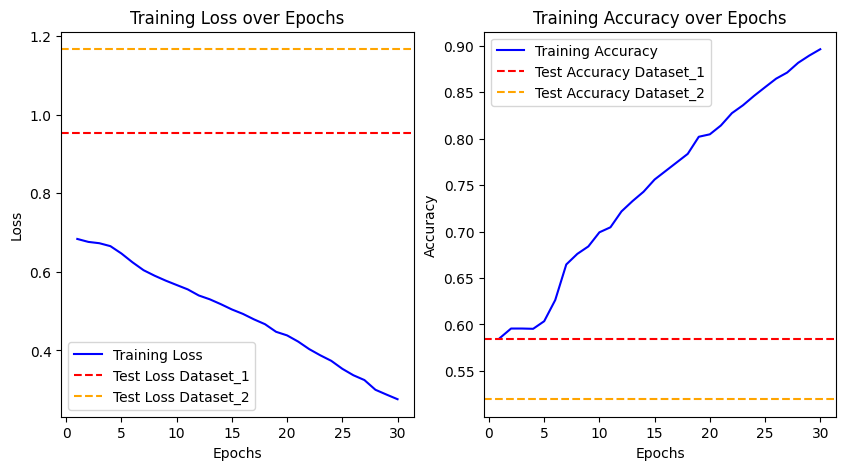

In [198]:
# Plotting Loss and Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.axhline(y=avg_test_loss, color='red', linestyle='--', label='Test Loss Dataset_1')
plt.axhline(y=avg_test_loss_2, color='orange', linestyle='--', label='Test Loss Dataset_2')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy Dataset_1')
plt.axhline(y=test_accuracy_2, color='orange', linestyle='--', label='Test Accuracy Dataset_2')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.show()